<a href="https://colab.research.google.com/github/myutman/DUL/blob/HW1/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.utils.data
from torch.optim import SGD, Adam
from torch.nn import Linear, Sigmoid, Dropout, Softmax, Sequential, ReLU
from torch.nn.functional import one_hot
import torch.nn as nn
import torch.nn.functional as F
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Задание 1

In [0]:
import numpy as np
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [0]:
def p(theta, x):
    return torch.exp(theta[x]) / torch.sum(torch.exp(theta))

def J(output):
    return -torch.sum(torch.log(output))

In [0]:
theta = torch.zeros(100, requires_grad=True)
sgd = SGD([theta], lr=0.03)

num_epochs = 20
losses = []
sample = sample_data()
size_train = int(len(sample) * 0.8)
size_test = len(sample) - size_train
train, test = torch.utils.data.random_split(sample, (size_train, size_test))

x_train = torch.tensor(train, dtype=torch.long)
x_test = torch.tensor(test, dtype=torch.long)
dataset = torch.utils.data.DataLoader(x_train, batch_size=1000, shuffle=True)
train_losses = []
test_losses = []
for i in range(num_epochs):
    for x1 in dataset:
        sgd.zero_grad()
        output = p(theta, x1)
        loss = J(output)
        losses.append(float(loss))
        loss.backward()
        sgd.step()
    train_losses.append(float(J(p(theta, x_train)).double()) / size_train)
    test_losses.append(float(J(p(theta, x_test)).double()) / size_test)

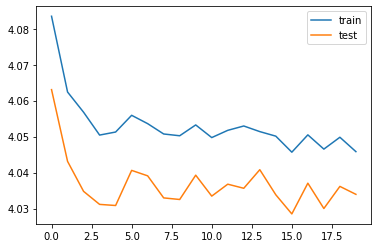

In [0]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

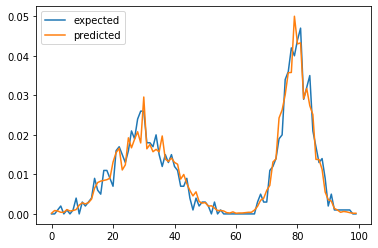

In [0]:
predicted = p(theta, range(100)).tolist()
expected = np.zeros(100)
for x in sample[:1000]:
    expected[x] += 1
expected /= 1000
expected = list(expected)

plt.plot(range(100), expected)
plt.plot(range(100), predicted)
plt.legend(['expected', 'predicted'])

# Задание 2
## 2.1

In [0]:
dist = np.load('/content/gdrive/My Drive/DUL/distribution.npy')

In [0]:
def gen_pair():
    x1 = np.random.choice(200, p=np.sum(dist, axis=1))
    x2 = np.random.choice(200, p=dist[x1] / np.sum(dist[x1]))
    return (x1, x2)

In [0]:
sample = np.array([gen_pair() for i in range(100000)])

In [0]:
size_train = int(len(sample) * 0.8)
size_test = len(sample) - size_train
train, test = torch.utils.data.random_split(sample, (size_train, size_test))

In [0]:
x_train = torch.tensor(train)
x_test = torch.tensor(test)
dataset = torch.utils.data.DataLoader(x_train, batch_size=200, shuffle=True)

In [0]:
def p(theta, x):
    return torch.exp(theta[x]) / torch.sum(torch.exp(theta))

def J(output):
    return -torch.mean(torch.log(output))

In [0]:
class MLP(nn.Module):
    def __init__(self, nin, nout, n_hidden):
        super(MLP, self).__init__()
        self.layers = []
        self.layers.extend([
            Linear(nin, 40),
            Sigmoid(),
            Dropout(0.5)
        ])
        for i in range(1, n_hidden - 1):
            self.layers.extend([
                Linear(40, 40),
                Sigmoid(),
                Dropout(0.5)
            ])
        self.layers.extend([
            Linear(40, nout),
            Softmax(dim=-1)
        ])
        torch.nn.init.normal_(self.layers[0].weight)
        self.model = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)
        
class LikelihoodModel(nn.Module):
    def __init__(self, n_hidden):
        super(LikelihoodModel, self).__init__()
        self.theta = nn.Parameter(torch.zeros(200))
        self.mlp = MLP(200, 200, n_hidden)
        
    def forward(self, batch):
        x1 = batch[:,0]
        x2 = batch[:,1]
        onehots = one_hot(x1, 200).float().to(device)
        px1 = p(self.theta, x1)
        px2 = self.mlp(onehots)[range(len(batch)), x2]
        output = px1 * px2
        return J(output)

In [0]:
num_epochs = 40

model = LikelihoodModel(7)
model.to(device)
sgd = Adam(model.parameters())
#sgd = SGD(model.parameters(), lr=0.03)

train_losses = []
test_losses = []
for i in tqdm(range(num_epochs)):
    avg_loss = 0
    for batch in dataset:
        batch.to(device)
        sgd.zero_grad()
        loss = model(batch)
        avg_loss += float(loss.double()) * len(batch)
        loss.backward()
        sgd.step()
    avg_loss /= len(x_train)
    train_losses.append(avg_loss)
    x_test.to(device)
    test_losses.append(float(model(x_test).double()))

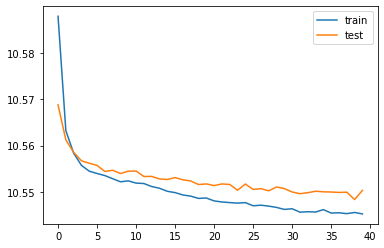

In [0]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

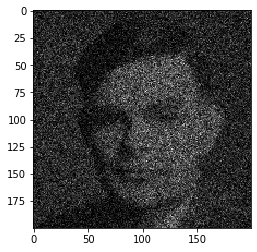

In [0]:
cnt = np.zeros((200, 200))
for x, y in sample:
    cnt[x, y] += 1

cnt /= len(sample)
plt.imshow(cnt, cmap='gray')

In [0]:
px1 = p(model.theta, range(200)).tolist()
predicted = []
for i in range(200):
    predicted.append((model.mlp(one_hot(torch.tensor([i]), 200).float().to(device))[0] * px1[i]).tolist())

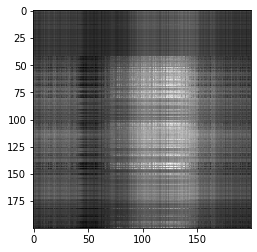

In [0]:
plt.imshow(predicted, cmap='gray')

## 2.2

In [0]:
class MaskedLayer(nn.Linear):
    def __init__(self, m_in, m_out):
        super(MaskedLayer, self).__init__(len(m_in), len(m_out))
        a = m_in.reshape((1, len(m_in)))
        b = m_out.reshape((len(m_out), 1))
        self.mask = (a <= b).float().to(device)
    
    def forward(self, x):
        self.weight.data = self.weight.data.to(device) * self.mask
        return super(MaskedLayer, self).forward(x)#F.linear(x, self.weight * self.mask, self.bias)
    
class MADE(nn.Module):
    def __init__(self, nin, n_blocks, n_hidden):
        super(MADE, self).__init__()
        self.nin = nin
        self.n_blocks = n_blocks
        start_m = torch.tensor(np.hstack([[i] * nin for i in range(n_blocks)]))
        m1 = start_m
        m2 = torch.randint(int(m1.min().long()), n_blocks - 1, (100,))
        self.layers = [
            MaskedLayer(m1, m2),
            Sigmoid(),
            Dropout(0.4)
        ]
        for i in range(1, n_hidden - 1):
            m1 = m2
            m2 = torch.randint(int(m1.min().long()), n_blocks - 1, (100,))
            self.layers.extend([
                MaskedLayer(m1, m2),
                Sigmoid(),
                Dropout(0.4)
            ])
        m1 = m2
        m2 = start_m - 1
        self.layers.append(MaskedLayer(m1, m2))
        torch.nn.init.normal_(self.layers[0].weight)
        self.seq = nn.Sequential(*self.layers)
        self.seq.to(device)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, x):
        z = self.seq(x)
        z = z.reshape((*x.shape[:-1], self.n_blocks, self.nin))
        ans = self.softmax(z).transpose(0, -2)
        #print(ans.shape)
        return ans

class MADELikelihoodModel(nn.Module):
    def __init__(self, n_hidden):
        super(MADELikelihoodModel, self).__init__()
        self.made = MADE(200, 2, n_hidden)
    
    def forward(self, batch):
        #print(batch.shape)
        x1 = batch[:,0]
        x2 = batch[:,1]
        x = one_hot(batch, 200).reshape(-1, 400).float()
        x.to(device)
        #print(x.shape)
        px1, px2 = self.made(x)
        #print(px1.shape)
        #print(px2.shape)
        #print(len(batch))
        #print(x1, x2)
        ox1 = px1[torch.arange(len(batch)), x1]
        ox2 = px2[torch.arange(len(batch)), x2]
        output = ox1 * ox2
        return J(output)

In [0]:
#sgd = SGD([theta, *mlp.parameters()], lr=0.03)
num_epochs = 150

model = MADELikelihoodModel(5)
model.to(device)
sgd = Adam([*model.parameters()])

train_losses = []
test_losses = []
for i in tqdm(range(num_epochs)):
    avg_loss = 0
    for batch in dataset:
        sgd.zero_grad()
        loss = model(batch.to(device))
        avg_loss += float(loss.double()) * len(batch)
        loss.backward()
        sgd.step()
    avg_loss /= len(x_train)
    train_losses.append(avg_loss)
    test_losses.append(float(model(x_test.to(device)).double()))

NameError: ignored

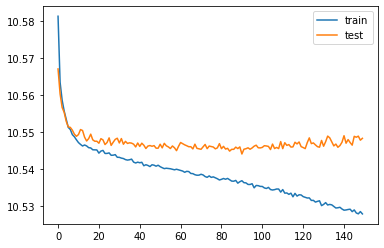

In [0]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

In [0]:
predicted = []
for i in range(200):
    predicted.append([])
    for j in range(200):
        px1, px2 = model.made(one_hot(torch.tensor([i, j]), 200).float().reshape(-1, 400).to(device))
        #print(px1, px2)
        predicted[i].append(float((px1[0][i] * px2[0][j]).float()))

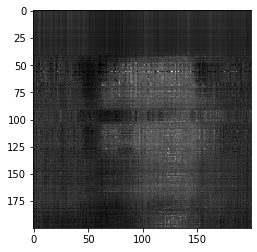

In [0]:
plt.imshow(predicted, cmap='gray')

# Задание 3
## 3.1

In [0]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, mask_type = 'A'):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.mask = torch.tensor(
            [[[[1] * kernel_size for _ in range(kernel_size // 2)] + 
                [[1] * ((kernel_size + (mask_type == 'B')) // 2) +
                 [0] * ((kernel_size + (mask_type == 'A')) // 2)] +
                [[0] * kernel_size for _ in range(kernel_size // 2)]
              for _ in range(in_channels)]
             for _ in range(out_channels)]
        ).to(device)
            
        
    def forward(self, x):
        #print(self.weight.data.shape, self.mask.shape)
        self.weight.data = self.weight.data * self.mask
        return super(MaskedConv2d, self).forward(x)

class ResidualGroup(nn.Module):
    def __init__(self, channels):
        super(ResidualGroup, self).__init__()
        self.seq = nn.Sequential(
            ReLU(),
            MaskedConv2d(channels, channels // 2, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(channels // 2),
            ReLU(),
            MaskedConv2d(channels // 2, channels // 2, kernel_size=3, stride=1, padding=1, mask_type='B'),
            nn.BatchNorm2d(channels // 2),
            ReLU(),
            MaskedConv2d(channels // 2, channels, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(channels),
        )
    
    def forward(self, x):
        return self.seq(x) + x

class PixelCNN(nn.Module):
    def __init__(self, n_hidden):
        super(PixelCNN, self).__init__()
        layers = [MaskedConv2d(12, 128, kernel_size=7, stride=1, padding=3)]
        for i in range(n_hidden):
            layers.append(ResidualGroup(128))
        layers.extend([
            ReLU(),
            MaskedConv2d(128, 12, kernel_size=1, stride=1, padding=0, mask_type='B'),
        ])
        self.seq = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        z = one_hot(x, 4).float()
        z = z.transpose(-1, -3).transpose(-1, -2).reshape(x.shape[0], 12, 28, 28)
        res = self.seq(z)
        res = res.reshape(x.shape[0], 3, 4, 28, 28).transpose(-1, -2).transpose(-1, -3)
        return self.softmax(res)

def J(data, output):
    data_vec = data.reshape(-1)
    output_vec = output.reshape(-1, 4)
    return -(output_vec[torch.arange(data_vec.shape[0]), data_vec]).log().mean()

In [0]:
import pickle
mnist_data = []
with open('/content/gdrive/My Drive/DUL/mnist-hw1.pkl', 'rb') as mnist_file:
    mnist_data = pickle.load(mnist_file)

In [0]:
X_train = torch.tensor(mnist_data['train'].transpose(0, 3, 1, 2), dtype=torch.long)
X_test = torch.tensor(mnist_data['test'].transpose(0, 3, 1, 2), dtype=torch.long).to(device)
dataset = torch.utils.data.DataLoader(X_train, batch_size=100)
dataset_test = torch.utils.data.DataLoader(X_test, batch_size=100)

In [34]:
num_epochs = 40
#num_epochs = 3

model = PixelCNN(12)
model.to(device)
sgd = Adam([*model.parameters()])

train_losses = []
test_losses = []
for i in tqdm(range(num_epochs)):
    avg_loss = 0
    model.train()
    for batch in dataset:
        sgd.zero_grad()
        loss = J(batch.to(device), model(batch.to(device)))
        #print(loss)
        avg_loss += float(loss.double()) * len(batch)
        loss.backward()
        sgd.step()
    avg_loss /= len(X_train)
    train_losses.append(avg_loss)
    model.eval()
    avg_loss = 0
    for batch in dataset_test:
        avg_loss += float(J(batch.to(device), model(batch.to(device))).double()) * len(batch)
    avg_loss /= len(X_test)
    test_losses.append(avg_loss)

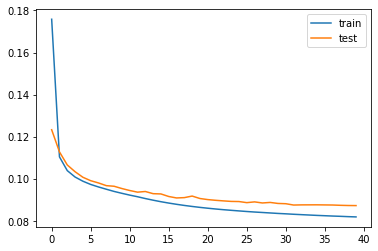

In [35]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

In [0]:
def sample_images(model, n=100):
    samples = np.zeros((n, 28, 28, 3), dtype=np.uint8)
    with torch.no_grad():
        for y in tqdm(range(28)):
            for x in range(28):
                for c in range(3):
                    xs = torch.tensor(samples).long().to(device)
                    ps = model(xs).cpu().numpy()
                    for i in range(n):
                        samples[i, y, x, c] = np.random.choice(
                            4, p=ps[i, c, y, x])    
                        
    samples *= 85
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(samples):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

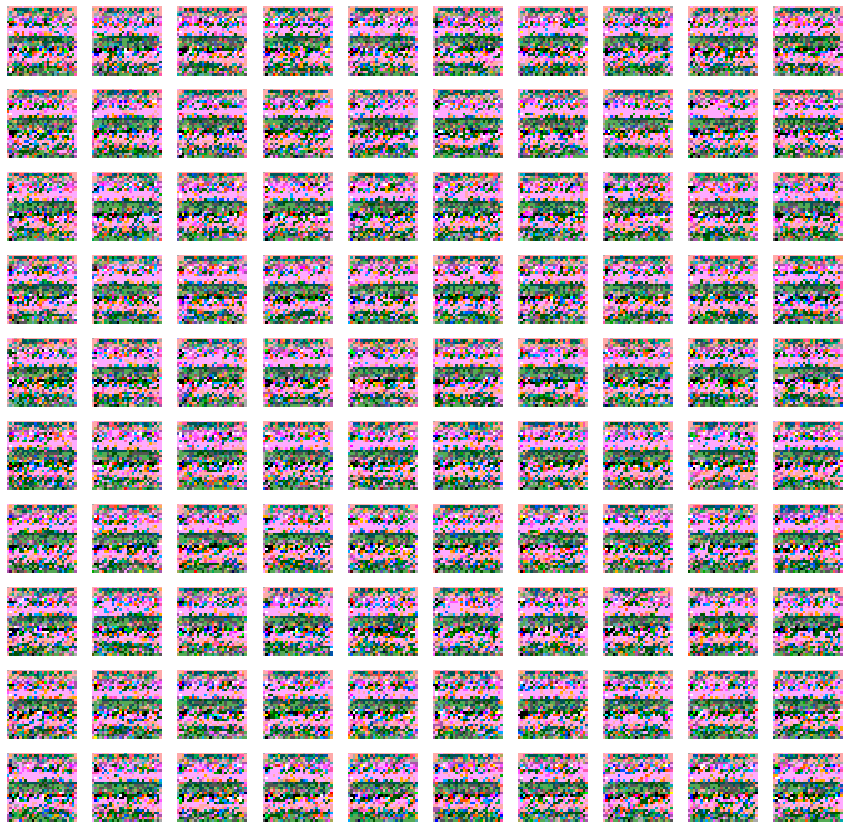

In [37]:
sample_images(model)

In [0]:
class MaskedMADEConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, m_in, m_out, kernel_size, stride, padding, mask_type = 'A'):
        super(MaskedMADEConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding)
        self.mask = torch.tensor(
            [[[[m_in[i] <= m_out[j]] * kernel_size for _ in range(kernel_size // 2)] + 
                [[m_in[i] <= m_out[j]] * ((kernel_size + (mask_type == 'B')) // 2) +
                 [0] * ((kernel_size + (mask_type == 'A')) // 2)] +
                [[0] * kernel_size for _ in range(kernel_size // 2)]
              for i in range(in_channels)]
             for j in range(out_channels)]
        ).to(device)
            
        
    def forward(self, x):
        self.weight.data = self.weight.data * self.mask
        return super(MaskedMADEConv2d, self).forward(x)

class ResidualGroup(nn.Module):
    def __init__(self, channels, m_in):
        super(ResidualGroup, self).__init__()
        m_out = torch.randint(int(m_in.min().long()), 3, (channels // 2,))
        layers = [
            ReLU(),
            MaskedMADEConv2d(channels, channels // 2, m_in, m_out, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(channels // 2),
            ReLU()
        ]
        m_in = m_out
        m_out = torch.randint(int(m_in.min().long()), 3, (channels // 2,))
        layers.extend([
            MaskedMADEConv2d(channels // 2, channels // 2, m_in, m_out, kernel_size=3, stride=1, padding=1, mask_type='B'),
            nn.BatchNorm2d(channels // 2),
            ReLU()
        ])

        m_in = m_out
        m_out = torch.randint(int(m_in.min().long()), 3, (channels,))
        layers.extend([
            MaskedMADEConv2d(channels // 2, channels, m_in, m_out, kernel_size=1, stride=1, padding=0, mask_type='B'),
            nn.BatchNorm2d(channels)
        ])
        self.m_out = m_out
        self.seq = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.seq(x) + x

class MADEPixelCNN(nn.Module):
    def __init__(self, n_hidden):
        super(MADEPixelCNN, self).__init__()
        m_start = torch.tensor([1] * 4 + [2] * 4 + [3] * 4)
        m_in = m_start
        m_out = torch.randint(int(m_in.min().long()), 3, (128,))
        layers = [MaskedMADEConv2d(12, 128, m_in, m_out, kernel_size=7, stride=1, padding=3)]
        m_in = m_out
        for i in range(n_hidden):
            res = ResidualGroup(128, m_in)
            m_in = res.m_out
            layers.append(res)

        m_out = m_start - 1
        layers.extend([
            ReLU(),
            MaskedMADEConv2d(128, 12, m_in, m_out, kernel_size=1, stride=1, padding=0, mask_type='B'),
        ])
        self.seq = nn.Sequential(*layers)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        z = one_hot(x, 4).float()
        z = z.transpose(-1, -3).transpose(-1, -2).reshape(x.shape[0], 12, 28, 28)
        res = self.seq(z)
        res = res.reshape(x.shape[0], 3, 4, 28, 28).transpose(-1, -2).transpose(-1, -3)
        return self.softmax(res)

def J(data, output):
    data_vec = data.reshape(-1)
    output_vec = output.reshape(-1, 4)
    return -(output_vec[torch.arange(data_vec.shape[0]), data_vec]).log().mean()

In [41]:
num_epochs = 40
#num_epochs = 10

model = MADEPixelCNN(12)
model.to(device)
sgd = Adam([*model.parameters()])

train_losses = []
test_losses = []
for i in tqdm(range(num_epochs)):
    avg_loss = 0
    model.train()
    for batch in dataset:
        sgd.zero_grad()
        loss = J(batch.to(device), model(batch.to(device)))
        #print(loss)
        avg_loss += float(loss.double()) * len(batch)
        loss.backward()
        sgd.step()
    avg_loss /= len(X_train)
    train_losses.append(avg_loss)
    model.eval()
    avg_loss = 0
    for batch in dataset_test:
        avg_loss += float(J(batch.to(device), model(batch.to(device))).double()) * len(batch)
    avg_loss /= len(X_test)
    test_losses.append(avg_loss)

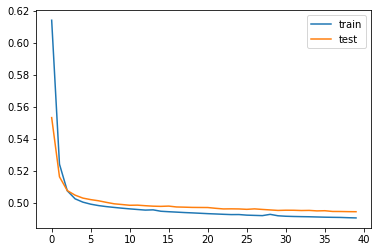

In [42]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train', 'test'])

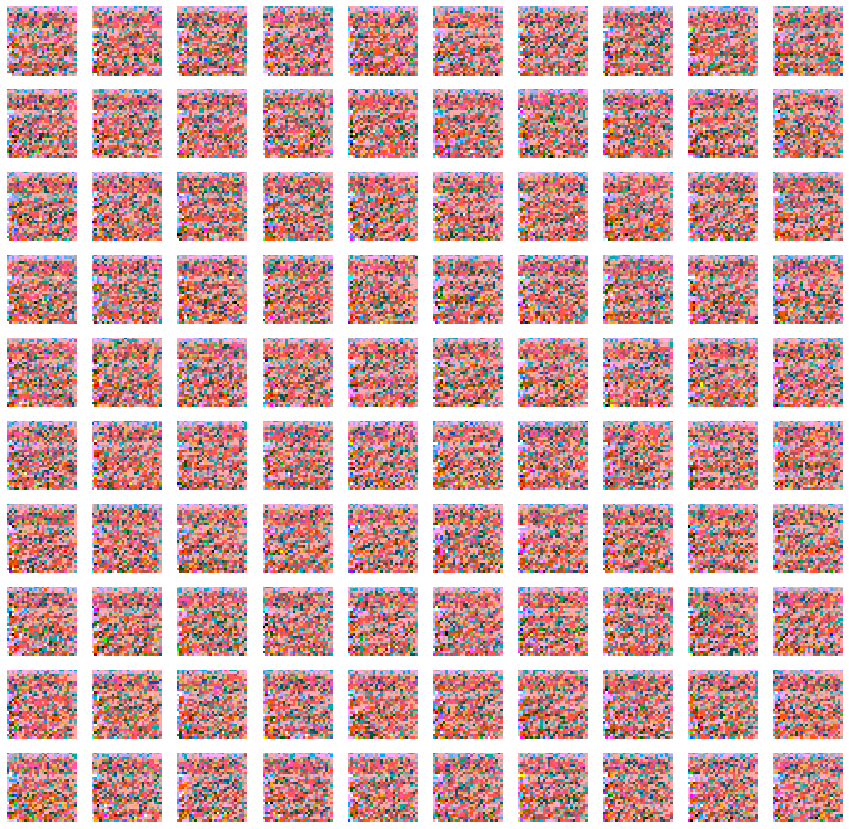

In [43]:
sample_images(model)